In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
torch.relu()

In [ ]:
nn.ReLU

In [163]:
# 1. Define a CNN architecture
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # First convolutional layer
        # Input: 3 channels (RGB), Output: 16 feature maps, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # Second convolutional layer
        # Input: 16 feature maps, Output: 32 feature maps, 3x3 kernel
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        # Assuming input images are 32x32, after two 2x2 pooling layers, we have 32/2/2 = 8
        # So the feature maps are 8x8 with 32 channels: 32 * 8 * 8 = 2048
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 output classes (e.g., for CIFAR-10 dataset)
    
    def forward(self, x):
        # Apply convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Flatten the feature maps
        x = x.view(-1, 32 * 8 * 8)
        
        # Apply fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        
        return x

# 2. Create an instance of the model
model = BasicCNN()
model = model.to(device)

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.8)

# 4. Load and preprocess data (example with CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.ImageFolder('../../data/raw/train/', transform=transform)
valset = torchvision.datasets.ImageFolder('../../data/raw/valid/', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)

In [164]:
class EarlyStopper:
    def __init__(self, max_iter : int = 10, patience : str = 2, min_delta : float = 0):
        self.max_iter = max_iter
        self.min_error = float('Inf')
        self.patience = patience
        self.counter = 0
    
    def check(self, val_error : float, model):
        
        if self.counter >= self.max_iter:
            return True
        
        if val_error < self.min_error:
            self.min_error = val_error
            torch.save(model.state_dict(), 'best_model.pth')
            self.counter = 0
        else:
            if self.counter >= self.patience:
                return True
            self.counter = self.counter + 1
        return False

In [165]:
ES = EarlyStopper(max_iter=10, patience=2, min_delta=0)

def train(epochs=5):
    
    time_started = time.time()
    train_errors = []
    val_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # Print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1}], time {time.time() - time_started} loss: {running_loss / 200:.3f}')
                running_loss = 0.0
            
        val_error = 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_error = val_error + criterion(outputs, labels) * images.size(0)
            val_error = val_error / len(valloader.dataset)
            print(f'epoch {epoch} val error: {val_error}')

    if ES.check(val_error, model):
        print('Finished Training')
        return
    

# 6. Run training
# train()  # Uncomment to run training

In [166]:
train(15)

[1, 200], time 4.659148216247559 loss: 2.297
[1, 400], time 5.515721797943115 loss: 2.275
[1, 600], time 6.363280534744263 loss: 2.198
[1, 800], time 7.211347579956055 loss: 2.070
[1, 1000], time 8.108929634094238 loss: 1.968
[1, 1200], time 9.664617776870728 loss: 1.886
[1, 1400], time 11.156718254089355 loss: 1.832
[1, 1600], time 12.66681694984436 loss: 1.777
[1, 1800], time 14.154914617538452 loss: 1.766
[1, 2000], time 15.678635358810425 loss: 1.734
[1, 2200], time 17.189730644226074 loss: 1.718
[1, 2400], time 18.72883176803589 loss: 1.690
[1, 2600], time 20.246371746063232 loss: 1.677
[1, 2800], time 21.75247097015381 loss: 1.644
epoch 0 val error: 1.6527642011642456
[2, 200], time 47.953481912612915 loss: 1.644
[2, 400], time 48.79355239868164 loss: 1.629
[2, 600], time 49.646628856658936 loss: 1.604
[2, 800], time 50.49319815635681 loss: 1.610
[2, 1000], time 51.375776290893555 loss: 1.594
[2, 1200], time 52.867732524871826 loss: 1.588
[2, 1400], time 54.378807067871094 loss: 

In [101]:
model.load_state_dict(torch.load('best_model.pth'))

C:\Users\micha\AppData\Local\Temp\ipykernel_7256\1559688700.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [102]:
val_error = 0
with torch.no_grad():
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_error = val_error + criterion(outputs, labels) * images.size(0)
    val_error = val_error / len(valloader.dataset)
    print(f'epoch NONE val error: {val_error}')

epoch NONE val error: 1.1674308776855469


---
# Checking

In [132]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

In [128]:
def predict(img):
    #tensor_image = transform(Image.fromarray(img)).unsqueeze(0)
    tensor_image = img_tensor.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(tensor_image)

    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Denormalize if your transform normalized the images
    img_np = img_np * 0.5 + 0.5  # Adjust based on your normalization values
    img_np = np.clip(img_np, 0, 1)    
    
    fig, (ax1, ax2) = plt.subplots(2, 1)
    
    ax1.imshow(img_np)
    proba = torch.nn.functional.softmax(output, dim=1)[0].tolist()
    sns.barplot(x=trainset.classes, y=proba, ax = ax2)
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45)
    plt.show()
    print(proba)

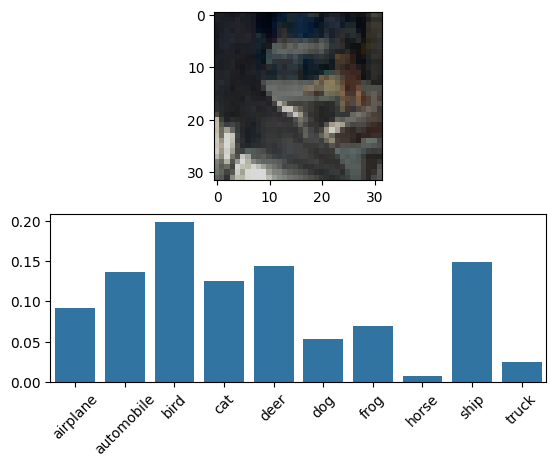

[0.09197390079498291, 0.13637155294418335, 0.1987992525100708, 0.12512052059173584, 0.14453724026679993, 0.05299113318324089, 0.06924711912870407, 0.007855124771595001, 0.14874224364757538, 0.024361854419112206]


In [157]:
img_tensor, label = valloader.dataset[29000]
predict(img_tensor)